In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
import sys,os,numpy as np, pandas as pd
from utils.preprocessREVI import preprocessor
pre = preprocessor()
m_type='M2'
lr = 2e-6
train_sz = 0.8
epochs = 2
dsel = 10

d_lst = [None, 'DDoS', 'DrDoS_LDAP','DrDoS_MSSQL','DrDoS_DNS','DrDoS_NetBIOS','DrDoS_NTP','DrDoS_UDP','DrDoS_SNMP','DrDoS_SSDP','syn_data']
d_class_lst = [None, 'DDoS', 'DrDoS_LDAP','DrDoS_MSSQL','DrDoS_DNS','DrDoS_NetBIOS','DrDoS_NTP','DrDoS_UDP','DrDoS_SNMP','DrDoS_SSDP','Syn']
print(d_lst[dsel])
df0, dt0, columns = pre.data_preprocess(f'./datasets/{d_lst[dsel]}.csv', mn='M2019', ac=[d_class_lst[dsel]])
# df0, dt0, columns = pre.data_preprocess('./datasets/Friday-WorkingHours-Afternoon-DDoS.pcap_REVI.csv', mn='M2', ac=[d_class_lst[dsel]], wbo=False)
df0 = pre.data_reshape(reshape_data=df0, reshape_cnn='1d')

syn_data
BENIGN  DoS GoldenEye  DoS Hulk  DoS Slowhttptest  DoS slowloris  Heartbleed  Syn
0       0              0         0                 0              0           1      1380015
1       0              0         0                 0              0           0          389
dtype: int64


In [3]:
M_lst = [None, 'M1', 'M2']
tr_evlst = [None, 'pcap_ISCX', 'pcap_REVI', 'pcap_REVI_ac', 'pcap_REVI_ac']

#模型選擇、資料集選擇
msel = 2
df1, dt1, columns = pre.data_preprocess(f'./datasets/Wednesday-WorkingHours.{tr_evlst[msel]}.csv', mn=M_lst[msel], ac=[d_class_lst[dsel]], wbo=False)
df1 = pre.data_reshape(reshape_data=df1, reshape_cnn='1d')
df2, dt2 = np.vstack((df0, df1)), np.vstack((dt0, dt1))

BENIGN  DoS GoldenEye  DoS Hulk  DoS Slowhttptest  DoS slowloris  Heartbleed  Syn
1       0              0         0                 0              0           0      319186
0       0              1         0                 0              0           0      159049
        1              0         0                 0              0           0        7647
        0              0         0                 1              0           0        5707
                                 1                 0              0           0        5109
                                 0                 0              1           0          11
dtype: int64


In [4]:
from utils.losses.SLCPLoss import SLCPLoss
import utils.model.DHRNet as models
latent=3
batch_size = 256
os.environ["CUDA_VISIBLE_DEVICES"]="0"
sd = 0
model_pth = f'./save_models/M2_sd_{sd}.pth'

cp_metas = torch.load(model_pth,map_location="cpu")
slcp_l = SLCPLoss(dt0.columns.__len__(), latent)
fc5_w, fc5_b = cp_metas['model_state_dict']['fc5.weight'], cp_metas['model_state_dict']['fc5.bias']
cp_metas['model_state_dict']['fc5.weight'], cp_metas['model_state_dict']['fc5.bias'] = torch.cat((fc5_w, torch.randn(1,3))), torch.cat((fc5_b, torch.randn(1)))
print(cp_metas['model_state_dict']['fc5.weight'], cp_metas['model_state_dict']['fc5.bias'])
net = models.DHRNet(dt0.columns.__len__(), latent=latent)
slcp_l.points = torch.nn.Parameter(torch.from_numpy(np.vstack((cp_metas['centers'], torch.zeros(1,3)))).float())
slcp_l.Dist.centers = slcp_l.points
print(slcp_l.Dist.centers)
slcp_l = slcp_l.cuda()
net.load_state_dict(cp_metas.get('model_state_dict'))
net.cuda()
cp_metas.keys()
# centers = slcp_l.points[-1].detach().numpy()
print((cp_metas.get('train_acc') + cp_metas.get('val_acc')) / 2)

tensor([[-0.0105,  0.3404,  0.3439],
        [ 0.2947, -0.4908, -0.3361],
        [-0.5594,  0.0182,  0.2342],
        [ 0.3610, -0.3434,  0.0465],
        [ 0.4090,  0.3506,  0.3094],
        [-0.0703, -0.5244,  0.0646],
        [-0.1813,  0.3082,  1.1950]]) tensor([ 0.1184,  0.2401, -0.2531, -0.3484, -0.1459,  0.3147, -0.4858])
Parameter containing:
tensor([[-0.5590, -2.5605,  1.8701],
        [-2.0983, -0.4613, -2.6759],
        [-2.2235,  2.1926,  1.2788],
        [ 2.3941, -2.2070, -1.7702],
        [ 2.8276,  1.2257,  2.1343],
        [ 1.6498,  3.0216, -1.8806],
        [ 0.0000,  0.0000,  0.0000]], requires_grad=True)
99.92525809698643


In [5]:
# 自訂 Train 迴圈做的事
def epoch_train(net, trainloader, optimizer, s_loss, rloss_weight=1.0, fc_c=4):        
    net.train()
    correct=0
    total=0
    total_loss = 0.0
    total_s_loss = 0.0
    total_reconst_loss = 0.0
    iter=0
    reconst_criterion = nn.MSELoss(reduction='sum')

    for i,data in enumerate(trainloader):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)
        _, targets = torch.max(labels.data, 1)

        # forward + backward + optimize
        _lg, cf, reconstruct, _ = net(inputs)
        logits, sloss = s_loss(cf, 0, labels=targets)

        reconst_loss = reconst_criterion(reconstruct, inputs) / labels.shape[0]
      
        # zero the parameter gradients
        optimizer.zero_grad()

        loss = sloss + reconst_loss * rloss_weight

        loss.backward()
        optimizer.step()
        total_loss = total_loss + loss.item()
        total_s_loss = total_s_loss + sloss
        if rloss_weight > 0:
            total_reconst_loss = total_reconst_loss + reconst_loss.item()
        
        _, predicted = torch.max(logits.data, 1)
        correct += (predicted == targets).sum().item()
        total += labels.size(0)
        iter = iter + 1

    return {'acc':(100 * (correct / total)), 'sloss':(total_s_loss/iter), 'rloss':(total_reconst_loss/iter), 'tloss':(total_loss/iter)}

In [6]:
def epoch_val(net,testloader, s_loss, rloss_weight=1.0):
    net.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    total_s_loss = 0.0
    total_reconst_loss = 0.0
    iter=0
    reconst_criterion = nn.MSELoss(reduction = 'sum')

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
            _, targets = torch.max(labels.data, 1)

            _lg, cf, reconstruct, _ = net(inputs)
            logits, sloss = s_loss(cf, 0, labels=targets)

            reconst_loss = reconst_criterion(reconstruct, inputs) / labels.shape[0]
            
            loss = sloss + reconst_loss * rloss_weight
            total_loss = total_loss + loss.item()
            total_s_loss = total_s_loss + sloss
            if rloss_weight > 0:
                total_reconst_loss = total_reconst_loss + reconst_loss.item()

            _, predicted = torch.max(logits.data, 1)
            correct += (predicted == targets).sum().item()
            total += labels.size(0)
            iter = iter + 1

    return {'acc':(100 * (correct / total)), 'sloss':(total_s_loss/iter), 'rloss':(total_reconst_loss/iter), 'tloss':(total_loss/iter)}

In [7]:
def get_features(net, testloader, s_loss):
    net.eval()
    reconst_criterion = torch.nn.MSELoss(reduction='none')
    opt_lst, tg_lst, loss_lst, prd_lst = np.empty((0,3)), np.empty((0)), np.empty((0)), np.empty((0))
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
            _, targets = torch.max(labels.data, 1)
            _, cf, _r, _e = net(inputs)
            logits, sloss = s_loss(cf, 0, labels=targets)
            bcel = reconst_criterion(_r, inputs)
            bcel = torch.sum(bcel.detach(), 2)
            _, predicted = torch.max(logits.data, 1)
            opt_lst = np.vstack((opt_lst, cf.detach().cpu().numpy()))
            tg_lst = np.hstack((tg_lst, targets.detach().cpu().numpy()))
            loss_lst = np.hstack((loss_lst, bcel.detach().cpu().numpy().flatten()))
            prd_lst = np.hstack((prd_lst, predicted.detach().cpu().numpy()))
    dfopt = pd.DataFrame(np.hstack((opt_lst, prd_lst.reshape(-1,1), tg_lst.reshape(-1,1), loss_lst.reshape(-1,1))), columns=['o_x', 'o_y', 'o_z', 'predict', 'groundtruth', 'reconst'] )
    return dfopt

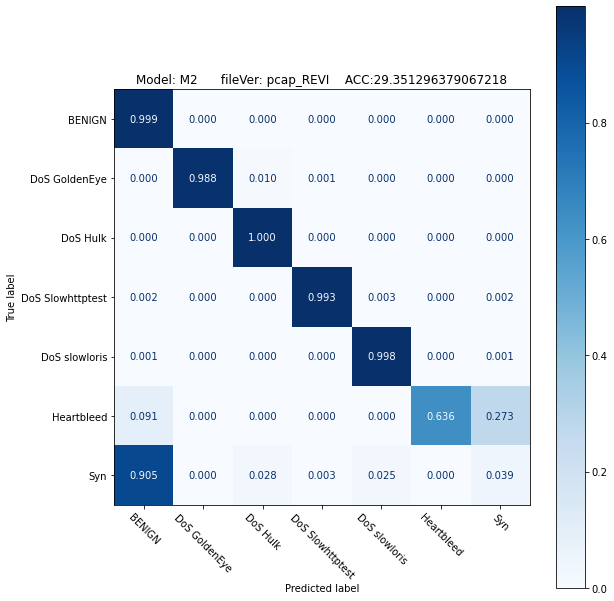

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
fig, ax = plt.subplots(figsize=(9,9))
tensor_x = torch.Tensor(df2) # transform to torch tensor
tensor_y = torch.Tensor(dt2)
inc_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
inc_t_dataloader = DataLoader(inc_dataset, batch_size=batch_size) # create your dataloader
eval_org = get_features(net, inc_t_dataloader, slcp_l)
with open(f'./logs/{M_lst[msel]}_Inc.log','a') as fd:
    with redirect_stdout(fd):
        # tn, fp, fn, tp = confusion_matrix(y_true=eval_org.groundtruth, y_pred=eval_org.predict).ravel()
        s_acc = accuracy_score(y_true=eval_org.groundtruth, y_pred=eval_org.predict)
        s_precision, s_recall, s_fscore, _ = precision_recall_fscore_support(y_true=eval_org.groundtruth, y_pred=eval_org.predict, average='weighted')
        print(f'no_od:{d_lst[dsel]},{s_acc},{s_precision},{s_recall},{s_fscore}')
ConfusionMatrixDisplay.from_predictions(y_true=eval_org.groundtruth, y_pred=eval_org.predict, cmap='Blues', values_format='.3f', ax=ax, normalize='true' ,display_labels=dt0.columns.to_list(), xticks_rotation=-45)
ax.set_title(f'Model: {M_lst[msel]}      fileVer: {tr_evlst[msel]}    ACC:{100 * eval_org[eval_org.predict == eval_org.groundtruth].shape[0] / eval_org.shape[0]}')#B_other:{"Yes" if msel == 3 else "No"}')
plt.tight_layout()
plt.savefig(f'./{M_lst[msel]}/{sd}/Incremental_{d_lst[dsel]}_noOD.png', transparent=False, facecolor='white')
plt.show()
plt.close()

In [9]:
from sklearn.model_selection import train_test_split
weight_decay= 3e-5
rloss_w = 1.0
# net.lyr_freeze()
os.environ["CUDA_VISIBLE_DEVICES"]="0"
X, y = df0, dt0.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=sd, train_size=train_sz)
X_train, X_test = torch.Tensor(X_train), torch.Tensor(X_test) # transform to torch tensor
y_train, y_test = torch.Tensor(y_train), torch.Tensor(y_test)
tr_dataset = TensorDataset(X_train, y_train) # create your datset
ts_dataset = TensorDataset(X_test, y_test) # create your datset
train_dataloader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True) # create your dataloader
test_dataloader = DataLoader(ts_dataset, batch_size=batch_size, shuffle=True) # create your dataloader
optimizer = optim.Adam(list(filter(lambda p:p.requires_grad, list(net.parameters()) + list(slcp_l.parameters()))), lr=lr, weight_decay=weight_decay)
for epoch in range(epochs):  # loop over the dataset multiple times
    print(f'<--------- epoch: {epoch + 1 }--------->')
    train_acc = epoch_train(net, train_dataloader, optimizer, slcp_l, rloss_weight=rloss_w)
    print(f"Train acc:{train_acc.get('acc')}%, sloss:{train_acc.get('sloss')}, rloss:{train_acc.get('rloss')} and total loss:{train_acc.get('tloss')}")
    test_acc = epoch_val(net, test_dataloader, rloss_weight=rloss_w, s_loss=slcp_l)
    print(f"Test acc:{test_acc.get('acc')}%, sloss:{test_acc.get('sloss')}, rloss:{test_acc.get('rloss')} and total loss:{test_acc.get('tloss')}")

<--------- epoch: 1--------->
Train acc:37.85396120519087%, sloss:3.8295116424560547, rloss:0.004170994542418873 and total loss:3.8336819491565475
Test acc:85.21339751739526%, sloss:2.812030076980591, rloss:0.0016959232999533209 and total loss:2.813727579700162
<--------- epoch: 2--------->
Train acc:89.86102797822738%, sloss:2.259225606918335, rloss:0.000922665464368316 and total loss:2.260150714831381
Test acc:99.06114509872103%, sloss:1.8296401500701904, rloss:0.0003953211732270011 and total loss:1.830035609376994


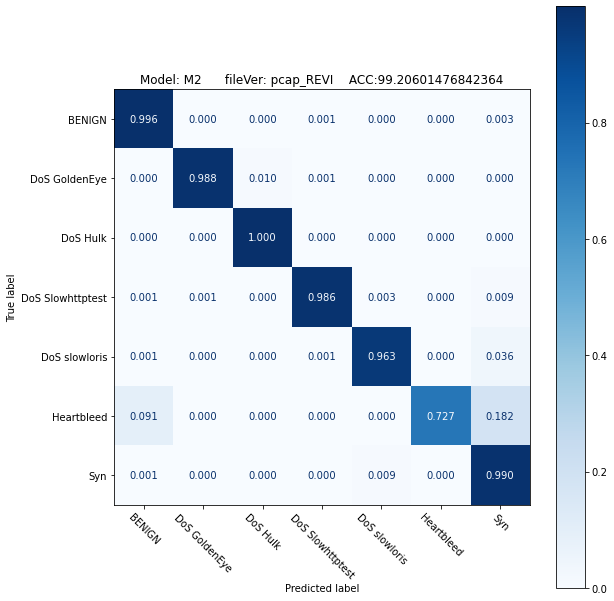

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9,9))
tensor_x = torch.Tensor(df2) # transform to torch tensor
tensor_y = torch.Tensor(dt2)

inc_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
inc_t_dataloader = DataLoader(inc_dataset, batch_size=batch_size) # create your dataloader
eval_org = get_features(net, inc_t_dataloader, slcp_l)
ConfusionMatrixDisplay.from_predictions(y_true=eval_org.groundtruth, y_pred=eval_org.predict, values_format='.3f', cmap='Blues', ax=ax, normalize='true' ,display_labels=dt0.columns.to_list(), xticks_rotation=-45)
ax.set_title(f'Model: {M_lst[msel]}      fileVer: {tr_evlst[msel]}    ACC:{100 * eval_org[eval_org.predict == eval_org.groundtruth].shape[0] / eval_org.shape[0]}')#B_other:{"Yes" if msel == 3 else "No"}')
plt.tight_layout()
plt.savefig(f'./{M_lst[msel]}/{sd}/Incremental_{d_lst[dsel]}.png', transparent=False, facecolor='white')
plt.show()
plt.close()

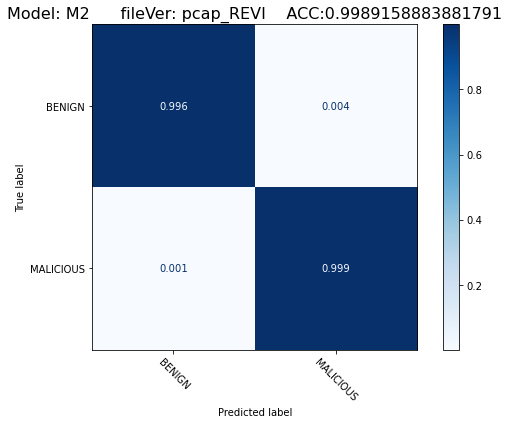

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
eval_org.predict[eval_org.predict > 0] = 1
eval_org.groundtruth[(eval_org.groundtruth > 0)] = 1
with open(f'./logs/{M_lst[msel]}_Inc.log','a') as fd:
    with redirect_stdout(fd):
        tn, fp, fn, tp = confusion_matrix(y_true=eval_org.groundtruth, y_pred=eval_org.predict).ravel()
        s_acc = accuracy_score(y_true=eval_org.groundtruth, y_pred=eval_org.predict)
        s_precision, s_recall, s_fscore, _ = precision_recall_fscore_support(y_true=eval_org.groundtruth, y_pred=eval_org.predict, average='binary')
        print(f'{d_lst[dsel]},{tn},{fp},{fn},{tp},{s_acc},{s_precision},{s_recall},{s_fscore}')
fig, ax = plt.subplots(figsize=(8,6))
parameters = {'axes.labelsize': 12,
          'axes.titlesize': 16}
plt.rcParams.update(parameters)
ConfusionMatrixDisplay.from_predictions(y_true=eval_org.groundtruth, y_pred=eval_org.predict, cmap='Blues', values_format='.3f', ax=ax, normalize='true' ,display_labels=['BENIGN', 'MALICIOUS'], xticks_rotation=-45)
ax.set_title(f'Model: {M_lst[msel]}      fileVer: {tr_evlst[msel]}    ACC:{s_acc}')
plt.tight_layout()
plt.savefig(f'./{M_lst[msel]}/{sd}/Incremental_{d_lst[dsel]}_Bin.png', transparent=False, facecolor='white')
plt.show()
plt.close()

In [12]:
# cmp = plt.get_cmap('tab20')(range(pre.sort_lst.__len__()))
# fig = plt.figure(figsize=(8,8))
# ax = fig.gca(projection='3d')
# print('scatter!!')
# ax.scatter(xs=eval_org.o_x, ys=eval_org.o_y, zs=eval_org.o_z, c=cmp[eval_org.groundtruth.astype('int').to_numpy()], marker='o', alpha=0.5)
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# plt.show()
# plt.close()

In [13]:
# fig, ax = plt.subplots(figsize=(10,5))
# thold = np.percentile(eval_org.reconst,[99])[0]
# ax.set_title(f'DDoS thold:{thold}')
# ax.set_ylabel('times')
# ax.set_xlabel('SSE loss')
# ax.hist(eval_org.reconst, 250, facecolor='g', alpha=0.5)
# plt.show()
# plt.close()